Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


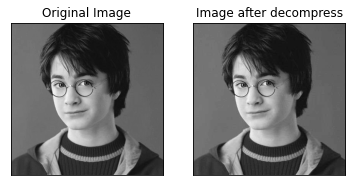

MSE =  8.449870349887618
PSNR =  38.86230315440153
SSIM =  0.9728972478941733
Compression Ratio =  0.3013137316233969
Time Compress:  0.9033975601196289


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:178: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:186: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [14]:
import matplotlib
import cv2
import collections
import math
import string
import os
import numpy as np
import time
from math import log
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim

from google.colab import drive
drive.mount('/content/drive')

#Thiết lập
########################################Thêm tên file ảnh cần nén
filename = 'harry.jpg'
########################################Tỉ lệ nén
ratio = 0.3

## thuật toán huffman
class node:
    def __init__(self, count, index , name="" ):
        self.count = float(count)
        self.index = index
        self.name  = name 
        if self.name=="" : self.name = index
        self.word = "" 
        self.isinternal = 0
    def __cmp__(self, other):
        return cmp(self.count, other.count)
    def report(self):
        if (self.index == 1 ) :
            print ('#Symbol\tCount\tCodeword')
        print ('%s\t(%2.2g)\t%s' % (self.name,self.count,self.word))
        pass
    def associate(self,internalnode):
        self.internalnode = internalnode
        internalnode.leaf = 1
        internalnode.name = self.name
        pass

class internalnode:
    def __init__(self):
        self.leaf = 0
        self.child = []
        pass
    def children(self,child0,child1):
        self.leaf = 0
        self.child.append(child0)
        self.child.append(child1)
        pass
        
def find(f, seq):
    for item in seq:
        if f(item): 
            return item

def iterate (c) :
   
    if ( len(c) > 1 ) :
   
    ## sắp xếp các nút theo số lượng, sử dụng hàm __cmp__ được xác định trong lớp nút
        deletednode = c[0]  #tạo bản sao của nút nhỏ nhất
        second = c[1].index ## chỉ mục của nút thứ hai nhỏ nhất
        
        # cộng  hai thành phần dưới cùng
        c[1].count += c[0].count 
        del c[0]

        root = iterate ( c )

        ## Điền thông tin mới vào danh sách
        ## tìm từ mã đã được tách / nối 
        co = find( lambda p: p.index == second , c )
        deletednode.word = co.word+'0'
        c.append( deletednode )
        co.word += '1'
        co.count -= deletednode.count   ## khôi phục số node lượng chính xác

        ## tạo ra các nhánh mới trong cây
        newnode0 = internalnode()
        newnode1 = internalnode()
        treenode = co.internalnode # tìm nút có hai nút con 
        treenode.children(newnode0,newnode1)
        deletednode.associate(newnode0)
        co.associate(newnode1)
        pass
    else :
        c[0].word = ""
        root = internalnode()
        c[0].associate(root)
        pass
    return root

def encode(sourcelist,code):

    answer = ""
    for s in sourcelist:
        co = find(lambda p: p.name == s, code)

        answer = answer + co.word

    return answer

def decode(string,root):
  
   
    answer = []
    clist = list( string )
    #duyệt bắt đầu từ gốc 
    currentnode = root
    for c in clist:
        if ( c=='\n' ):  continue #trường hợp đặc biệt cho các ký tự mới
        assert ( c == '0' )or( c == '1')
        currentnode = currentnode.child[int(c)]
        if currentnode.leaf != 0:
            answer.append( str(currentnode.name) )
            currentnode = root
        pass
    assert (currentnode == root) 
    return answer


def makenodes(probs):
    
    m=0
    c=[]
    for p in probs:
        m += 1 ;
        c.append( node( p[1], m, p[0] ) )
        pass
    return c

##  Zig-zag 
def zig_zag(input_matrix, block_size):
    z = np.empty([block_size*block_size])
    index = -1
    bound = 0
    for i in range(0, 2 * block_size - 1):
        if i < block_size:
            bound = 0
        else:
            bound = i - block_size + 1
        for j in range(bound, i - bound + 1):
            index += 1
            if i % 2 == 1:
                z[index] = input_matrix[j, i-j]
            else:
                z[index] = input_matrix[i-j, j]
    return z


def zig_zag_reverse(input_matrix):
    block_size = 8
    output_matrix = np.empty([block_size, block_size])
    index = -1
    bound = 0
    input_m = []
    for i in range(0, 2 * block_size - 1):
        if i < block_size:
            bound = 0
        else:
            bound = i - block_size + 1
        for j in range(bound, i - bound + 1):
            index += 1
            if i % 2 == 1:
                output_matrix[j, i - j] = input_matrix[0][index]
            else:
                output_matrix[i - j, j] = input_matrix[0][index]
    return output_matrix


def MSE(img1, img2):
    return ((img1.astype(np.float) - img2.astype(np.float)) ** 2).mean(axis=None)


def PSNR(mse): 
    return 10 * log(((255 * 255) / mse), 10)


def SSIM(img1, img2):
    return ssim(img1.astype(np.float), img2.astype(np.float), data_range=img2.max() - img2.min())


def Compression_Ratio(filepath):
    Ori_img = os.stat(filepath).st_size
    Ori_div = 2048
    Com_div = Ori_div * ratio
    Ori_img = Ori_img/Ori_div
    Com_img = os.path.getsize('/content/drive/MyDrive/Colab_Notebooks/JPEG_Compression/(Decompressed)' + filename)
    Com_img = Com_img/Com_div
    CR = Ori_img/float(Com_img)
    return CR

def main():
    filepath = ('/content/drive/MyDrive/Colab_Notebooks/JPEG_Compression/' + filename)
    img = cv2.imread(filepath, 0)

    # Ma trận lượng tử hóa
    qtable = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                       [12, 12, 14, 19, 26, 58, 60, 55],
                       [14, 13, 16, 24, 40, 57, 69, 56],
                       [14, 17, 22, 29, 51, 87, 80, 62],
                       [18, 22, 37, 56, 68, 109, 103, 77],
                       [24, 35, 55, 64, 81, 104, 113, 92],
                       [49, 64, 78, 87, 103, 121, 120, 101],
                       [72, 92, 95, 98, 112, 100, 103, 99]])
    
    
    ################## JPEG compression ##################
    start = time.time()
    iHeight, iWidth = img.shape[:2]
    zigZag = []
    for startY in range(0, iHeight, 8):
        for startX in range(0, iWidth, 8):
            block = img[startY:startY+8, startX:startX+8]

            # Tính DCT cho khối
            block_t = np.float32(block)  # chuyển đổi sang số thực
            dct = cv2.dct(block_t) 

            # lượng tử hóa các hệ số DCT
            block_q = np.floor(np.divide(dct, qtable)+0.5)

            # Zig Zag
            zigZag.append(zig_zag(block_q, 8))

    # DPCM cho giá trị DC
    dc = []
    dc.append(zigZag[0][0])  # giữ nguyên giá trị đầu tiên
    for i in range(1, len(zigZag)):
        dc.append(zigZag[i][0]-zigZag[i-1][0])

    # RLC cho giá trị AC
    rlc = []
    zeros = 0
    for i in range(0, len(zigZag)):
        zeros = 0
        for j in range(1, len(zigZag[i])):
            if (zigZag[i][j] == 0):
                zeros += 1
            else:
                rlc.append(zeros)
                rlc.append(zigZag[i][j])
                zeros = 0
        if(zeros != 0):
            rlc.append(zeros)
            rlc.append(0)


    #### Huffman ####


    # Huffman DPCM
    # Tìm tần suất xuất hiện cho mỗi giá trị của danh sách
    counterDPCM = collections.Counter(dc)

    # Xác định danh sách các giá trị dưới dạng danh sách các cặp (điểm, Tần suất tương ứng)
    probsDPCM = []
    for key, value in counterDPCM.items():
        probsDPCM.append((key, np.float32(value)))

    # Tạo danh sách các nút cho thuật toán Huffman
    symbolsDPCM = makenodes(probsDPCM)

    # chạy thuật toán Huffman trên một danh sách các "nút". Nó trả về một con trỏ đến gốc của một cây mới của "các nút bên trong".
    rootDPCM = iterate(symbolsDPCM)

    # Mã hóa danh sách các ký hiệu nguồn.
    sDPMC = encode(dc, symbolsDPCM)


    # Huffman RLC
    # Tìm tần suất xuất hiện cho mỗi giá trị của danh sách
    counterRLC = collections.Counter(rlc)

    # Xác định danh sách giá trị dưới dạng danh sách các cặp (điểm, Tần suất tương ứng)
    probsRLC = []
    for key, value in counterRLC.items():
        probsRLC.append((key, np.float32(value)))

    # Tạo danh sách các nút cho thuật toán Huffman 
    symbolsRLC = makenodes(probsRLC)

    # chạy thuật toán Huffman trên một danh sách các "nút". Nó trả về một con trỏ đến gốc của một cây mới của "các nút bên trong".
    root = iterate(symbolsRLC)

    # Mã hóa danh sách các ký hiệu nguồn.
    sRLC = encode(rlc, symbolsRLC)
    stop = time.time() # thời gian kết thúc nén



    ################## JPEG decompression ##################

    #### Huffman ####

    # Huffman DPCM 
    # Giải mã một chuỗi nhị phân bằng cách sử dụng cây Huffman được truy cập thông qua root
    dDPCM = decode(sDPMC, rootDPCM)
    decodeDPMC = []
    for i in range(0, len(dDPCM)):
        decodeDPMC.append(float(dDPCM[i]))

    # Huffman RLC
    # Giải mã một chuỗi nhị phân bằng cách sử dụng cây Huffman được truy cập thông qua root
    dRLC = decode(sRLC, root)
    decodeRLC = []
    for i in range(0, len(dRLC)):
        decodeRLC.append(float(dRLC[i]))

    # Inverse DPCM
    inverse_DPCM = []
    inverse_DPCM.append(decodeDPMC[0])  # giá trị đầu tiên giữ nguyên
    for i in range(1, len(decodeDPMC)):
        inverse_DPCM.append(decodeDPMC[i] + inverse_DPCM[i-1])

    # Inverse RLC
    inverse_RLC = []
    for i in range(0, len(decodeRLC)):
        if (i % 2 == 0):
            if(decodeRLC[i] != 0.0):
                if(i+1 < len(decodeRLC) and decodeRLC[i+1] == 0):
                    for j in range(1, int(decodeRLC[i])):
                        inverse_RLC.append(0.0)
                else:
                    for j in range(0, int(decodeRLC[i])):
                        inverse_RLC.append(0.0)
        else:
            inverse_RLC.append(decodeRLC[i])
    new_img = np.empty(shape=(iHeight, iWidth))
    height = 0
    width = 0
    temp = []
    temp2 = []
    for i in range(0, len(inverse_DPCM)):
        temp.append(inverse_DPCM[i])
        for j in range(0, 63):
            temp.append((inverse_RLC[j+i*63]))
        temp2.append(temp)

        # inverse Zig-Zag và nghịch đảo Lượng tử hóa các hệ số DCT
        inverse_blockq = np.multiply(np.reshape(
            zig_zag_reverse(temp2), (8, 8)), qtable)
        
        # inverse DCT
        inverse_dct = cv2.idct(inverse_blockq)
        for startY in range(height, height+8, 8):
            for startX in range(width, width+8, 8):
                new_img[startY:startY+8, startX:startX+8] = inverse_dct
        width = width + 8
        if(width == iHeight):
            width = 0
            height = height + 8
        temp = []
        temp2 = []
    np.place(new_img, new_img > 255, 255) 
    np.place(new_img, new_img < 0, 0) 


 ################ Hiển thị ảnh ##################
    plt.subplot(121), plt.imshow(img, 'gray'), plt.title('Original Image')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(new_img, 'gray'), plt.title('Image after decompress')
    plt.xticks([]), plt.yticks([])
    plt.show()

    # Lưu ảnh sau khi giải nén
    cv2.imwrite('/content/drive/MyDrive/Colab_Notebooks/JPEG_Compression/(Decompressed)' + filename, new_img)
    
    # Tính MSE
    mse = MSE(img, new_img)
    print("MSE = ", mse)

    # Tính PSNR
    print("PSNR = ", PSNR(mse))

    # Tính SSIM
    print("SSIM = ", SSIM(img, new_img))

    # Compression Ratio
    print("Compression Ratio = ", Compression_Ratio(filepath))
    
    # Thời gian nén
    print("Time Compress: ", stop-start)

if __name__ == "__main__":
     main()